# Tutorial 2: Spectral early warning signals with *ewstools*

By the end of this tutorial you should know how to:
- Compute and visualise changes in the power spectrum over a rolling window
- Compute spectral early warning signals as in [Bury et al. (2020) Royal Soc. Interface](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482)

Total run time : 4.8 s on Macbook Air (M1, 2020)


## Motivation

The power spectrum of a time series changes as a bifurcation is approached. The way in which the power spectrum changes can depend on the bifurcation type (see e.g. [Wiesenfeld (1985)](https://link.springer.com/article/10.1007/BF01010430)). As such, we should be able to derive EWS based on the power spectrum (spectral EWS) that can discriminate between certain types of bifurcation. This was the primary goal of the study by [Bury et al. (2020) Royal. Soc. Interface](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482). In investigating the analyitcal forms for the power spectrum for dynamical systems close to bifurcations, it was also found that spectral EWS can have favourable scaling with distance to the bifurcation.

This notebook demonstrates how to compute spectral EWS, applying them to simulation data from the Ricker model and the Rosenzweig-MacArthur model.

## Import libraries

In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [24]:
import numpy as np
np.random.seed(0) # Set seed for reproducibility
import pandas as pd
import matplotlib.pyplot as plt
import os

import plotly.express as px
from IPython.display import Image

import ewstools
from ewstools.models import simulate_ricker, simulate_rosen_mac

## Simulate model data and detrend

Here, we simulate the Ricker model going through a fold bifurcation, and the Rosenzweig-MacArthur (RM) model going through a Hopf bifurcation. Since, the RM model is a continuous-time model, simulated with dt=0.01, we will downsample the output to have the same number of data points as the Ricker simulation.

In [3]:
series_ricker = simulate_ricker(tmax=500, F=[0,2.7])
series_rm = simulate_rosen_mac(tmax=500, a=[12,16], dt=0.01).iloc[::100]

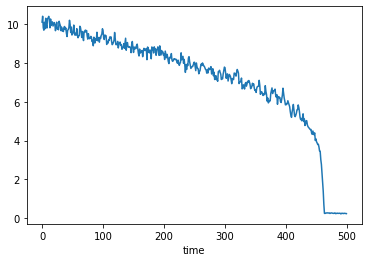

In [4]:
series_ricker.plot();

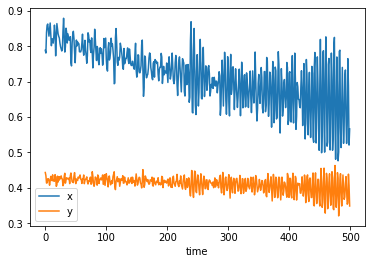

In [5]:
series_rm.plot();

As per usual, we now define a [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object for each time series we wish to analyse. Note this only takes in 1D time series, so the x and y components of the Rosenzweig-Macarthur model must be assigned separately. We will just eyeball transition times for this tutorial. A more rigorous approach could be to use change-point algorithms, or use the time that the bifurcation is crossed in the model.

In [6]:
ts_ricker = ewstools.TimeSeries(series_ricker, transition=440)
ts_rm_x = ewstools.TimeSeries(series_rm['x'], transition=420)
ts_rm_y = ewstools.TimeSeries(series_rm['y'], transition=420)

We will detrend the time series using a Lowess filter with a span of 0.2.

In [7]:
ts_ricker.detrend(method='Lowess', span=0.2)
ts_rm_x.detrend(method='Lowess', span=0.2)
ts_rm_y.detrend(method='Lowess', span=0.2)

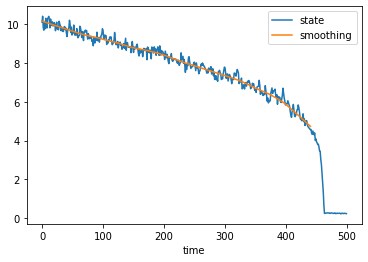

In [8]:
ts_ricker.state[['state','smoothing']].plot();

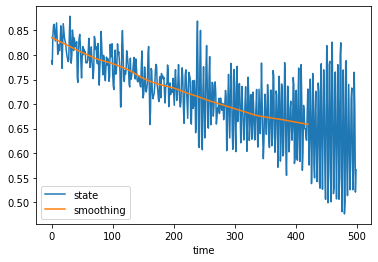

In [9]:
ts_rm_x.state[['state','smoothing']].plot();

## Compute the power spectrum over a rolling window

Spectral EWS are derived from the power spectrum. So first, we need to compute the power spectrum, and do so over a rolling window to capture changes that may occur. A rolling window moves incrementally across the residual time-series. At each increment, the power spectrum of the data within the window is estimated using Welch’s method [(Welch 1967)](https://ieeexplore.ieee.org/abstract/document/1161901?casa_token=jrTKXfGVEH4AAAAA:_68iwAAWXljxGjslyfBJ1f7Yt0iDeY8iVEouvfWKvfmnzKfRIf7Eh6O0ofo6rL0KtSqDsmjcLNA). This involves computing the periodogram across several Hamming windows with a specified length and offset, and computing their average, as illustrated below.

<img src="images/welch_rolling.png" width="300" align="left"/>


This apporoach is implemented in *ewstools* with the method [`compute_spectrum()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_spectrum). We will use a rolling window of 0.5 and a Hamming window length of 80 data points. (The Hamming window length must be smaller than the number of data points in the rolling window!)

In [10]:
ts_ricker.compute_spectrum(rolling_window=0.5, ham_length=40)
ts_rm_x.compute_spectrum(rolling_window=0.5, ham_length=40)
ts_rm_y.compute_spectrum(rolling_window=0.5, ham_length=40)

After applying this method, the attribute *pspec* should be filled with data on the power spectrum as a function of time.

In [11]:
ts_ricker.pspec.head()

,frequency,power,time
0,-3.141593,0.000586,219.0
1,-2.984513,0.000705,219.0
2,-2.827433,0.000986,219.0
3,-2.670354,0.001309,219.0
4,-2.513274,0.000770,219.0


Let's now plot the power spectrum at these different times in the approach to each bifurcation.


### Power spectra in the approach to the fold bifurcation

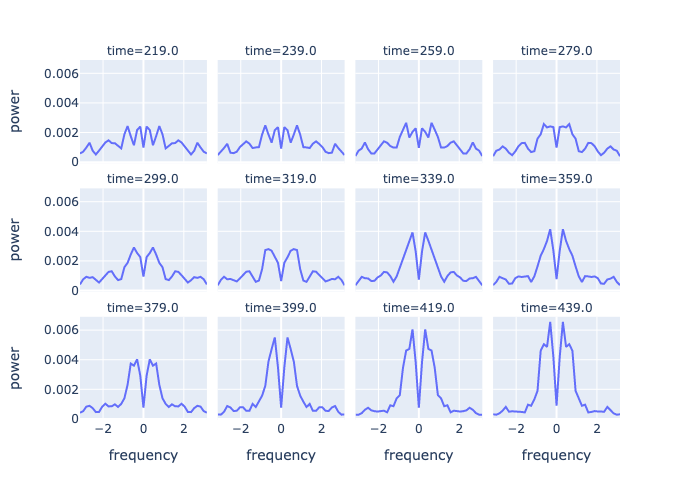

In [12]:
fig = px.line(ts_ricker.pspec, x='frequency', y='power', facet_col='time', facet_col_wrap=4)
Image(fig.to_image())
# To get interactive version run fig.show()

### Power spectra in the approach to the Hopf bifurcation

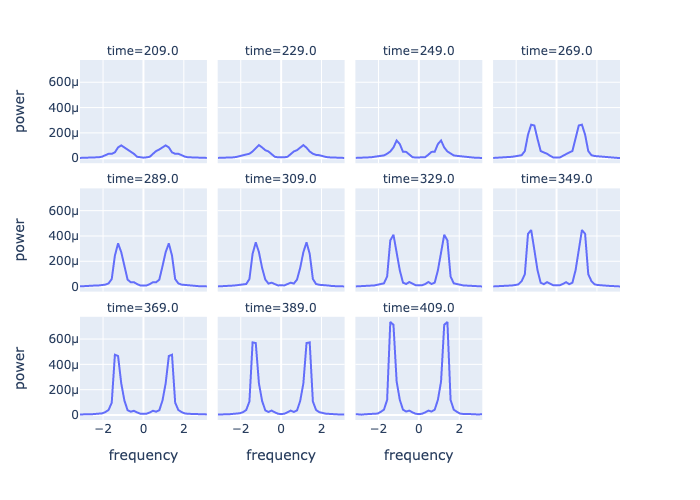

In [13]:
fig = px.line(ts_rm_x.pspec, x='frequency', y='power', facet_col='time', facet_col_wrap=4)
Image(fig.to_image())

In the approach the fold bifurcation, the power spectrum becomes dominated by smaller frequencies. In the approach to the Hopf bifurcation, the power spectrum becomes dominated by the frequency of oscillations that occur at the Hopf bifurcation. This is clearly visible in these simulations.

## Computing spectral EWS - Smax

There are many metrics that may be derived from the power spectrum. The maximum value of the power spectrum (Smax) has been shown to have favourable scaling properties with the approach of a bifurcation [(Bury et al. 2020)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482). This may be computed with the method [`compute_smax()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_smax).

In [14]:
ts_ricker.compute_smax()
ts_rm_x.compute_smax()
ts_rm_y.compute_smax()

Let's compute the variance as well to give it something to compare to:

In [15]:
ts_ricker.compute_var(rolling_window=0.5)
ts_rm_x.compute_var(rolling_window=0.5)
ts_rm_y.compute_var(rolling_window=0.5)

We will also compute the kendall tau values to measure the strength of the trends.

In [16]:
ts_ricker.compute_ktau()
ts_rm_x.compute_ktau()
ts_rm_y.compute_ktau()

Finally, let's visualise this with the method [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly)

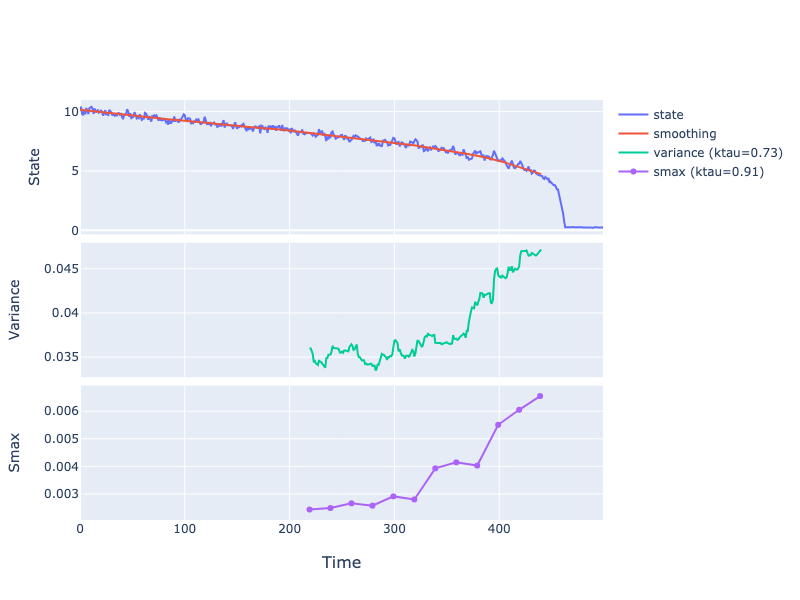

In [17]:
fig = ts_ricker.make_plotly()
Image(fig.to_image())

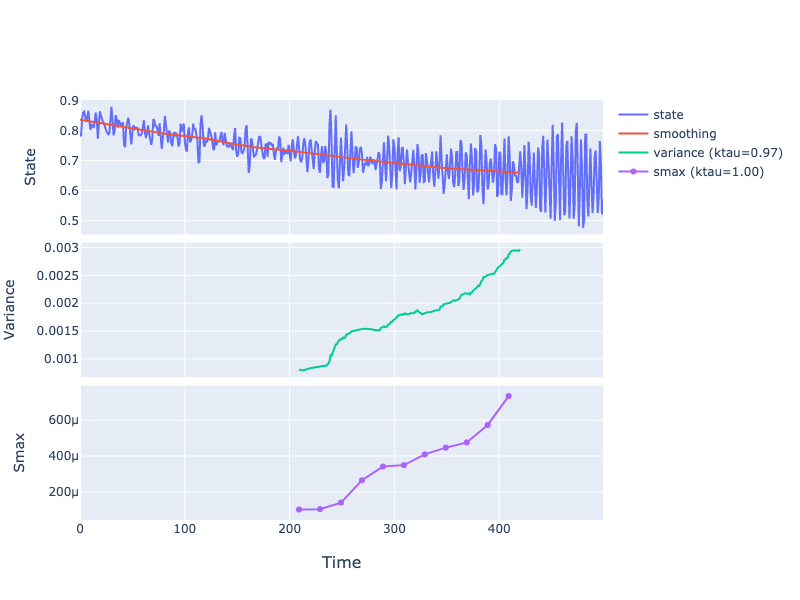

In [18]:
fig = ts_rm_x.make_plotly()
Image(fig.to_image())

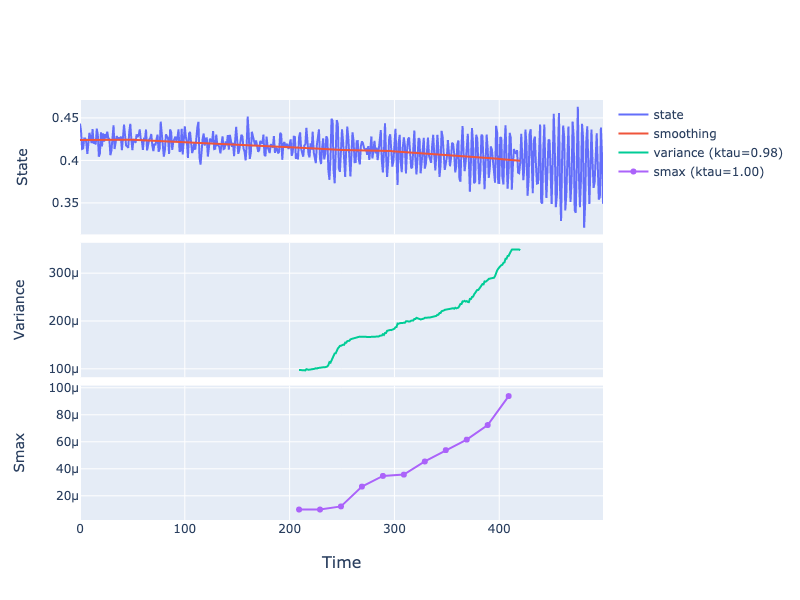

In [19]:
fig = ts_rm_y.make_plotly()
Image(fig.to_image())

We see that that in both cases Smax provides a slightly stronger indication than the variance, due to its favourable scaling properties (scales with the inverse square of the distance to the bifurcation, as opposed to simply the inverse of the distance to the bifurcation).

## Compute spectral EWS - AIC weights

Another metric proposed in [Bury et al. 2020](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482) is AIC weights describing which canonical form the power spectrum belongs to - that of a Hopf bifurcation, that of a fold bifurcation, or that of a white noise process. These weights can be computed using the [`compute_spec_type()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.compute_spec_type) method.

In [20]:
ts_ricker.compute_spec_type()
ts_rm_x.compute_spec_type()
ts_rm_y.compute_spec_type()

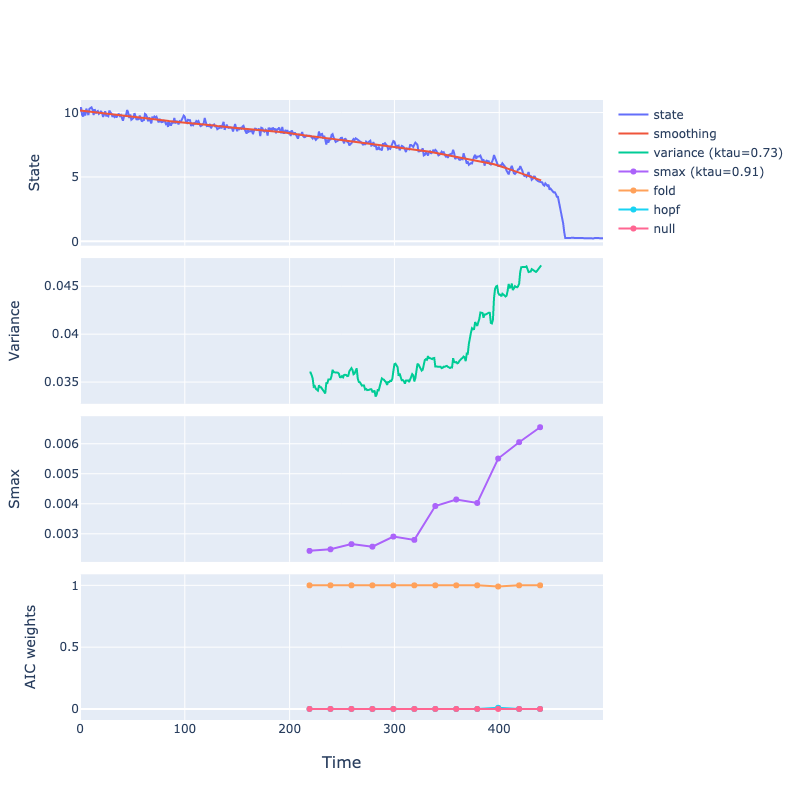

In [21]:
fig = ts_ricker.make_plotly()
Image(fig.to_image())

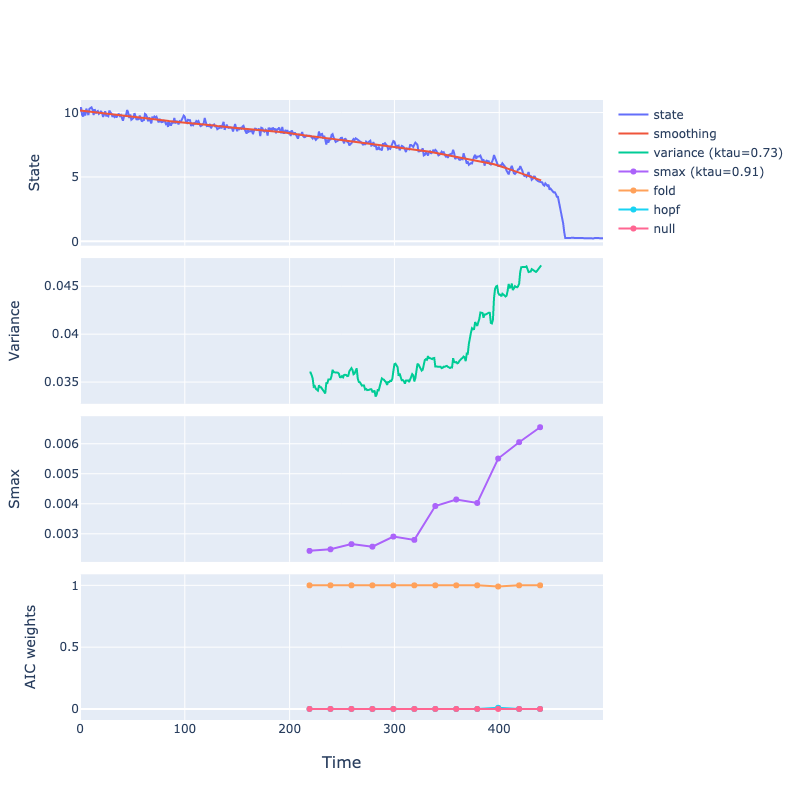

In [22]:
ts_rm_x.make_plotly()
Image(fig.to_image())

We see that, for these simulations, the AIC weights are able to correct identify a fold vs. a Hopf bifurcation, based on the power spectrum.

In [23]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))

Notebook took 4.8s to run
